In [177]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score

# Prediction performance evaluation

In [178]:
df = pd.read_csv('../data/chexpert/chexpert.sample.test.csv')

white = 'White'
asian = 'Asian'
black = 'Black'

# Race Classification

In [179]:
data_dir = 'predictions/'

cnn_pred_race = pd.read_csv(data_dir + 'predictions.test.race.csv')
cnn_pred_disease = pd.read_csv(data_dir + 'predictions.test.disease.csv')
cnn_pred_sex = pd.read_csv(data_dir + 'predictions.test.sex.csv')

In [180]:
preds_race = np.stack([cnn_pred_race['class_0'],cnn_pred_race['class_1'],cnn_pred_race['class_2']]).transpose()
targets_race = np.array(cnn_pred_race['target'])

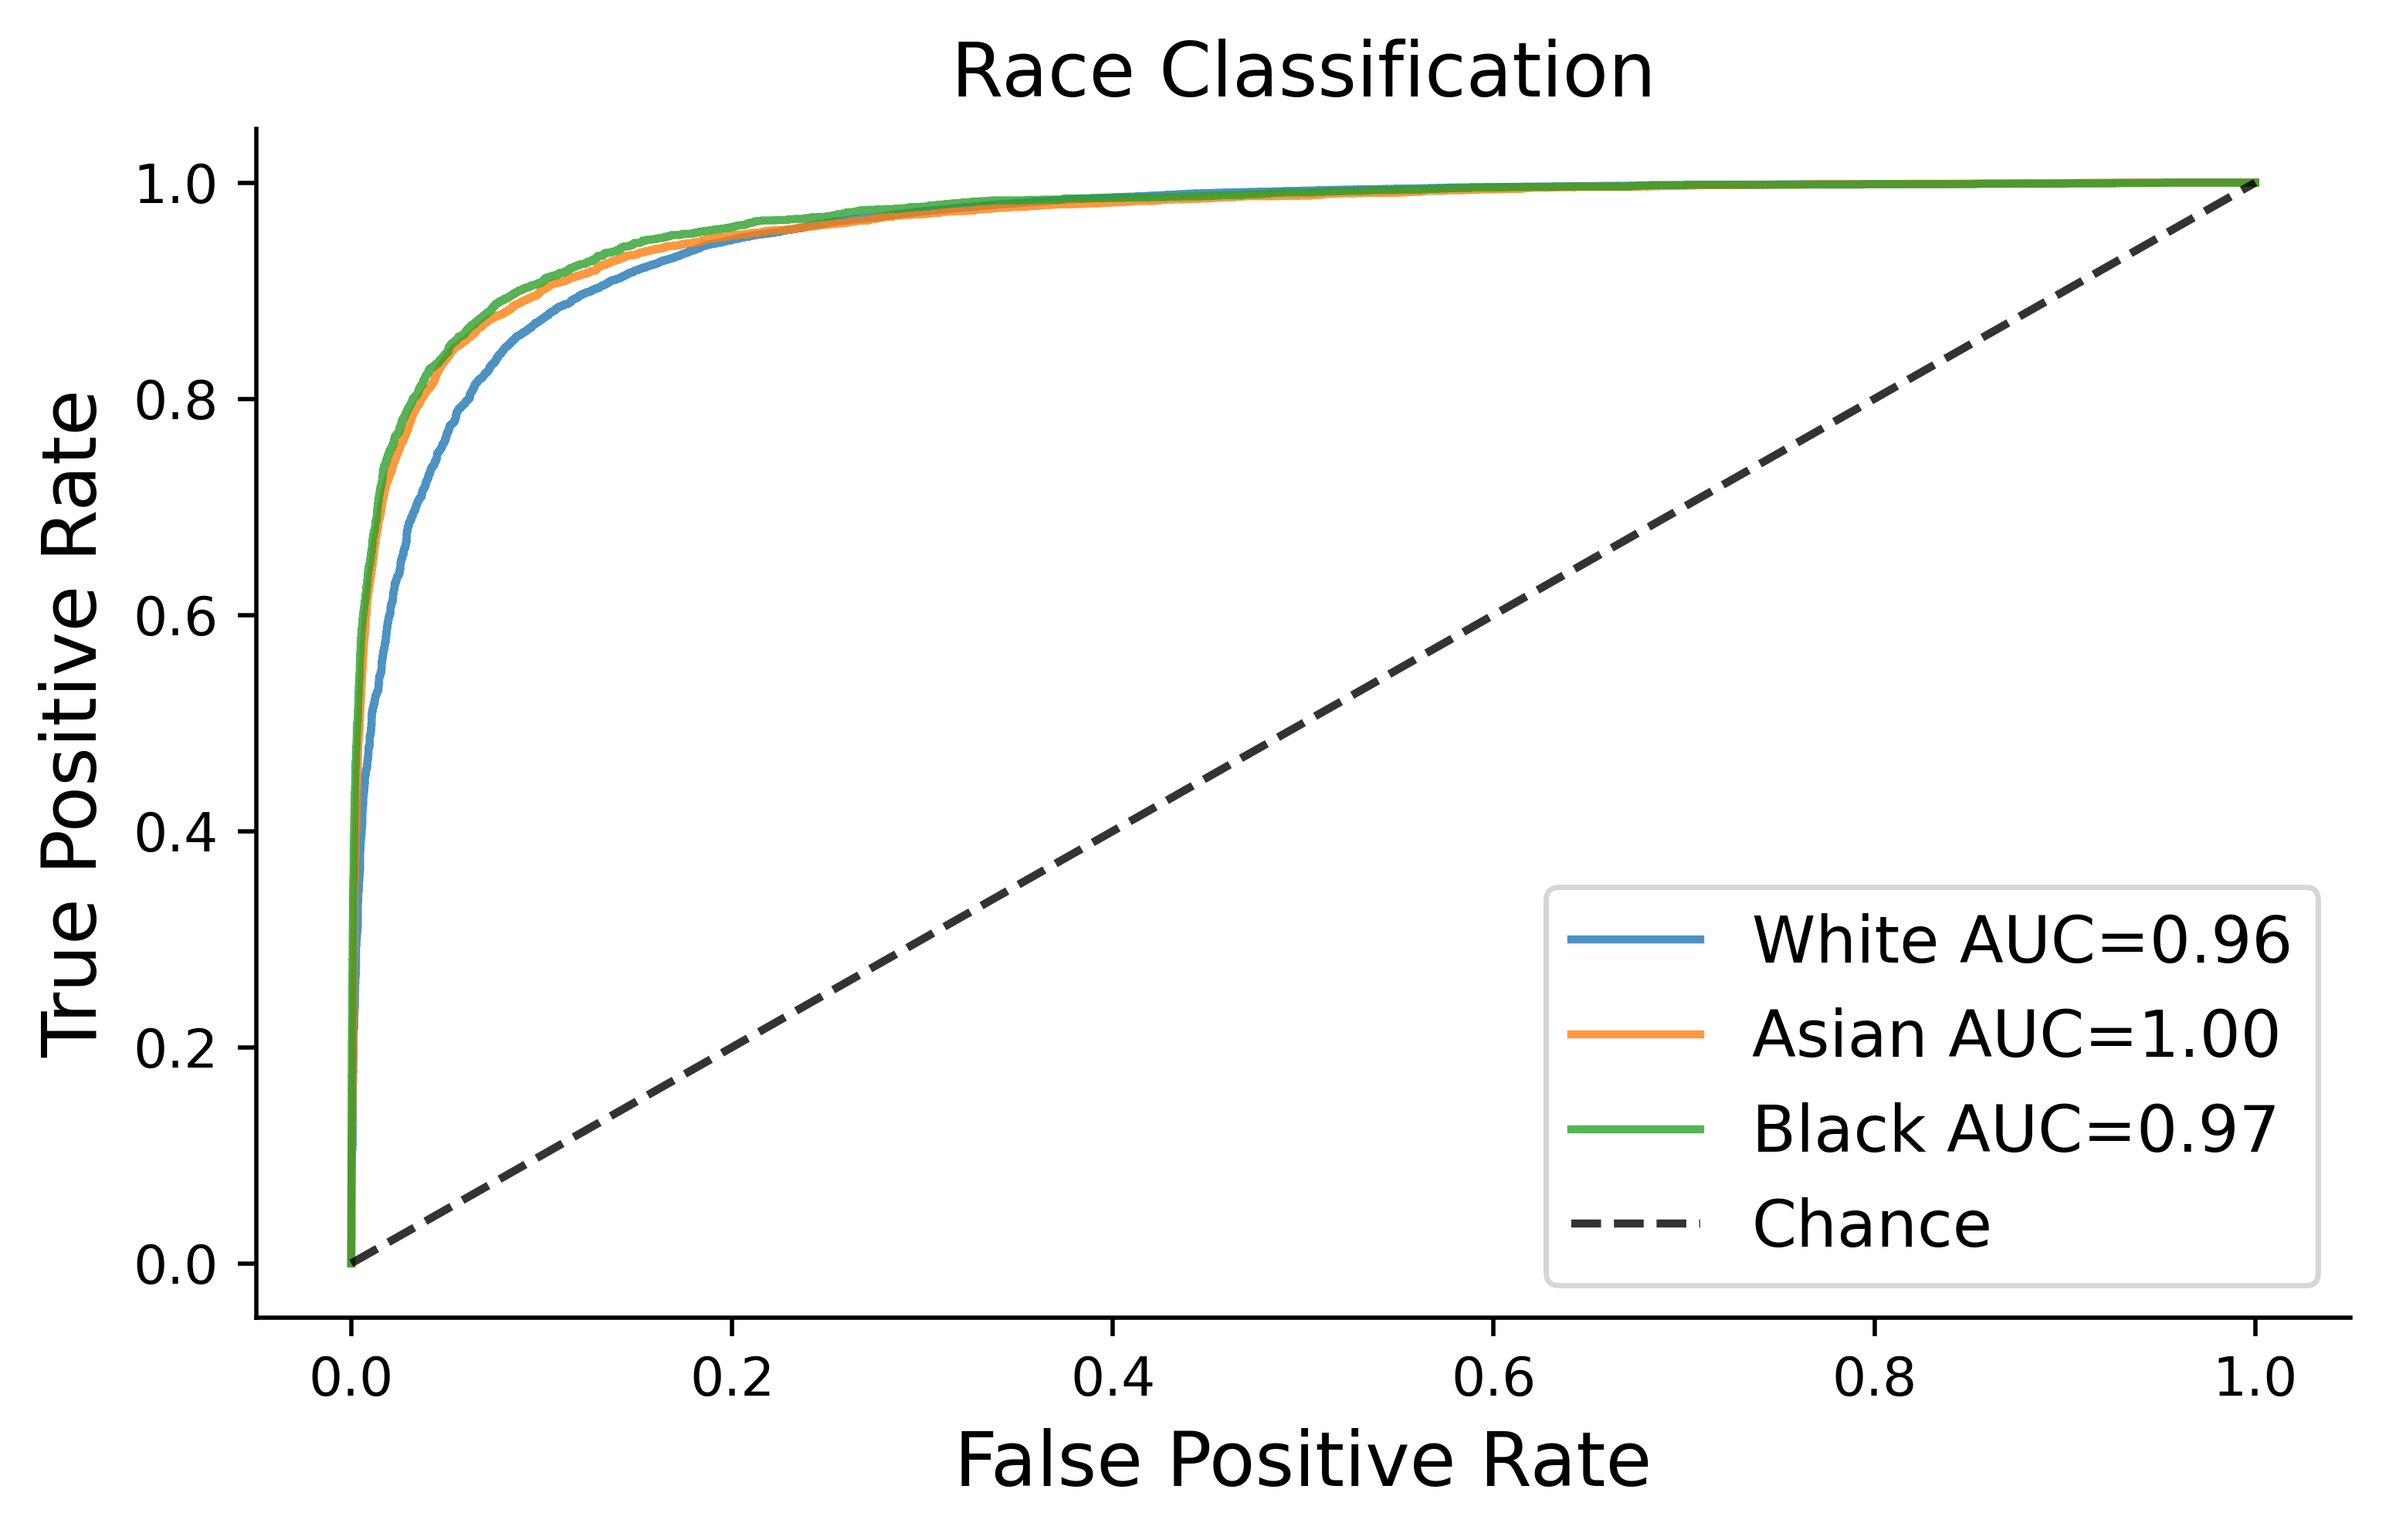

In [181]:
# WHITE
pos_label = 0
y = np.array(targets_race)
y[targets_race != pos_label] = 0
y[targets_race == pos_label] = 1
fpr_w, tpr_w, _ = roc_curve(y, preds_race[:,pos_label])
roc_auc_w = auc(fpr_w, tpr_w)

# ASIAN
pos_label = 1
y = np.array(targets_race)
y[targets_race != pos_label] = 0
y[targets_race == pos_label] = 1
fpr_a, tpr_a, _ = roc_curve(y, preds_race[:,pos_label])
auc_a = auc(fpr_a, tpr_a)

# BLACK
pos_label = 2
y = np.array(targets_race)
y[targets_race != pos_label] = 0
y[targets_race == pos_label] = 1
fpr_b, tpr_b, _ = roc_curve(y, preds_race[:,pos_label])
roc_auc_b = auc(fpr_b, tpr_b)

fig, ax = plt.subplots(figsize=(7,4), dpi=500)
plt.plot(fpr_w, tpr_w, lw=1.5, alpha=.8, label='White AUC=%0.2f' % roc_auc_w)
plt.plot(fpr_a, tpr_a, lw=1.5, alpha=.8, label='Asian AUC=%0.2f' % roc_auc_a)
plt.plot(fpr_b, tpr_b, lw=1.5, alpha=.8, label='Black AUC=%0.2f' % roc_auc_b)
ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.title('Race Classification', fontsize=14)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.spines[['right', 'top']].set_visible(False)
plt.show()

# fig.savefig("CNN-race.png", bbox_inches='tight', dpi=300)

# Sex classification

In [182]:
# for subgroup analysis
cnn_pred_sex['race'] = df['race']
cnn_pred_sex_w = cnn_pred_sex[cnn_pred_sex['race'] == white]
cnn_pred_sex_a = cnn_pred_sex[cnn_pred_sex['race'] == asian]
cnn_pred_sex_b = cnn_pred_sex[cnn_pred_sex['race'] == black]

In [183]:
preds_sex = np.stack([cnn_pred_sex_w['class_0'],cnn_pred_sex_w['class_1']]).transpose()
targets_sex = np.array(cnn_pred_sex_w['target'])
fpr_w, tpr_w, _ = roc_curve(targets_sex, preds_sex[:,1])
roc_auc_w = auc(fpr_w, tpr_w)

preds_sex = np.stack([cnn_pred_sex_a['class_0'],cnn_pred_sex_a['class_1']]).transpose()
targets_sex = np.array(cnn_pred_sex_a['target'])
fpr_a, tpr_a, _ = roc_curve(targets_sex, preds_sex[:,1])
roc_auc_a = auc(fpr_a, tpr_a)

preds_sex = np.stack([cnn_pred_sex_b['class_0'],cnn_pred_sex_b['class_1']]).transpose()
targets_sex = np.array(cnn_pred_sex_b['target'])
fpr_b, tpr_b, _ = roc_curve(targets_sex, preds_sex[:,1])
roc_auc_b = auc(fpr_b, tpr_b)


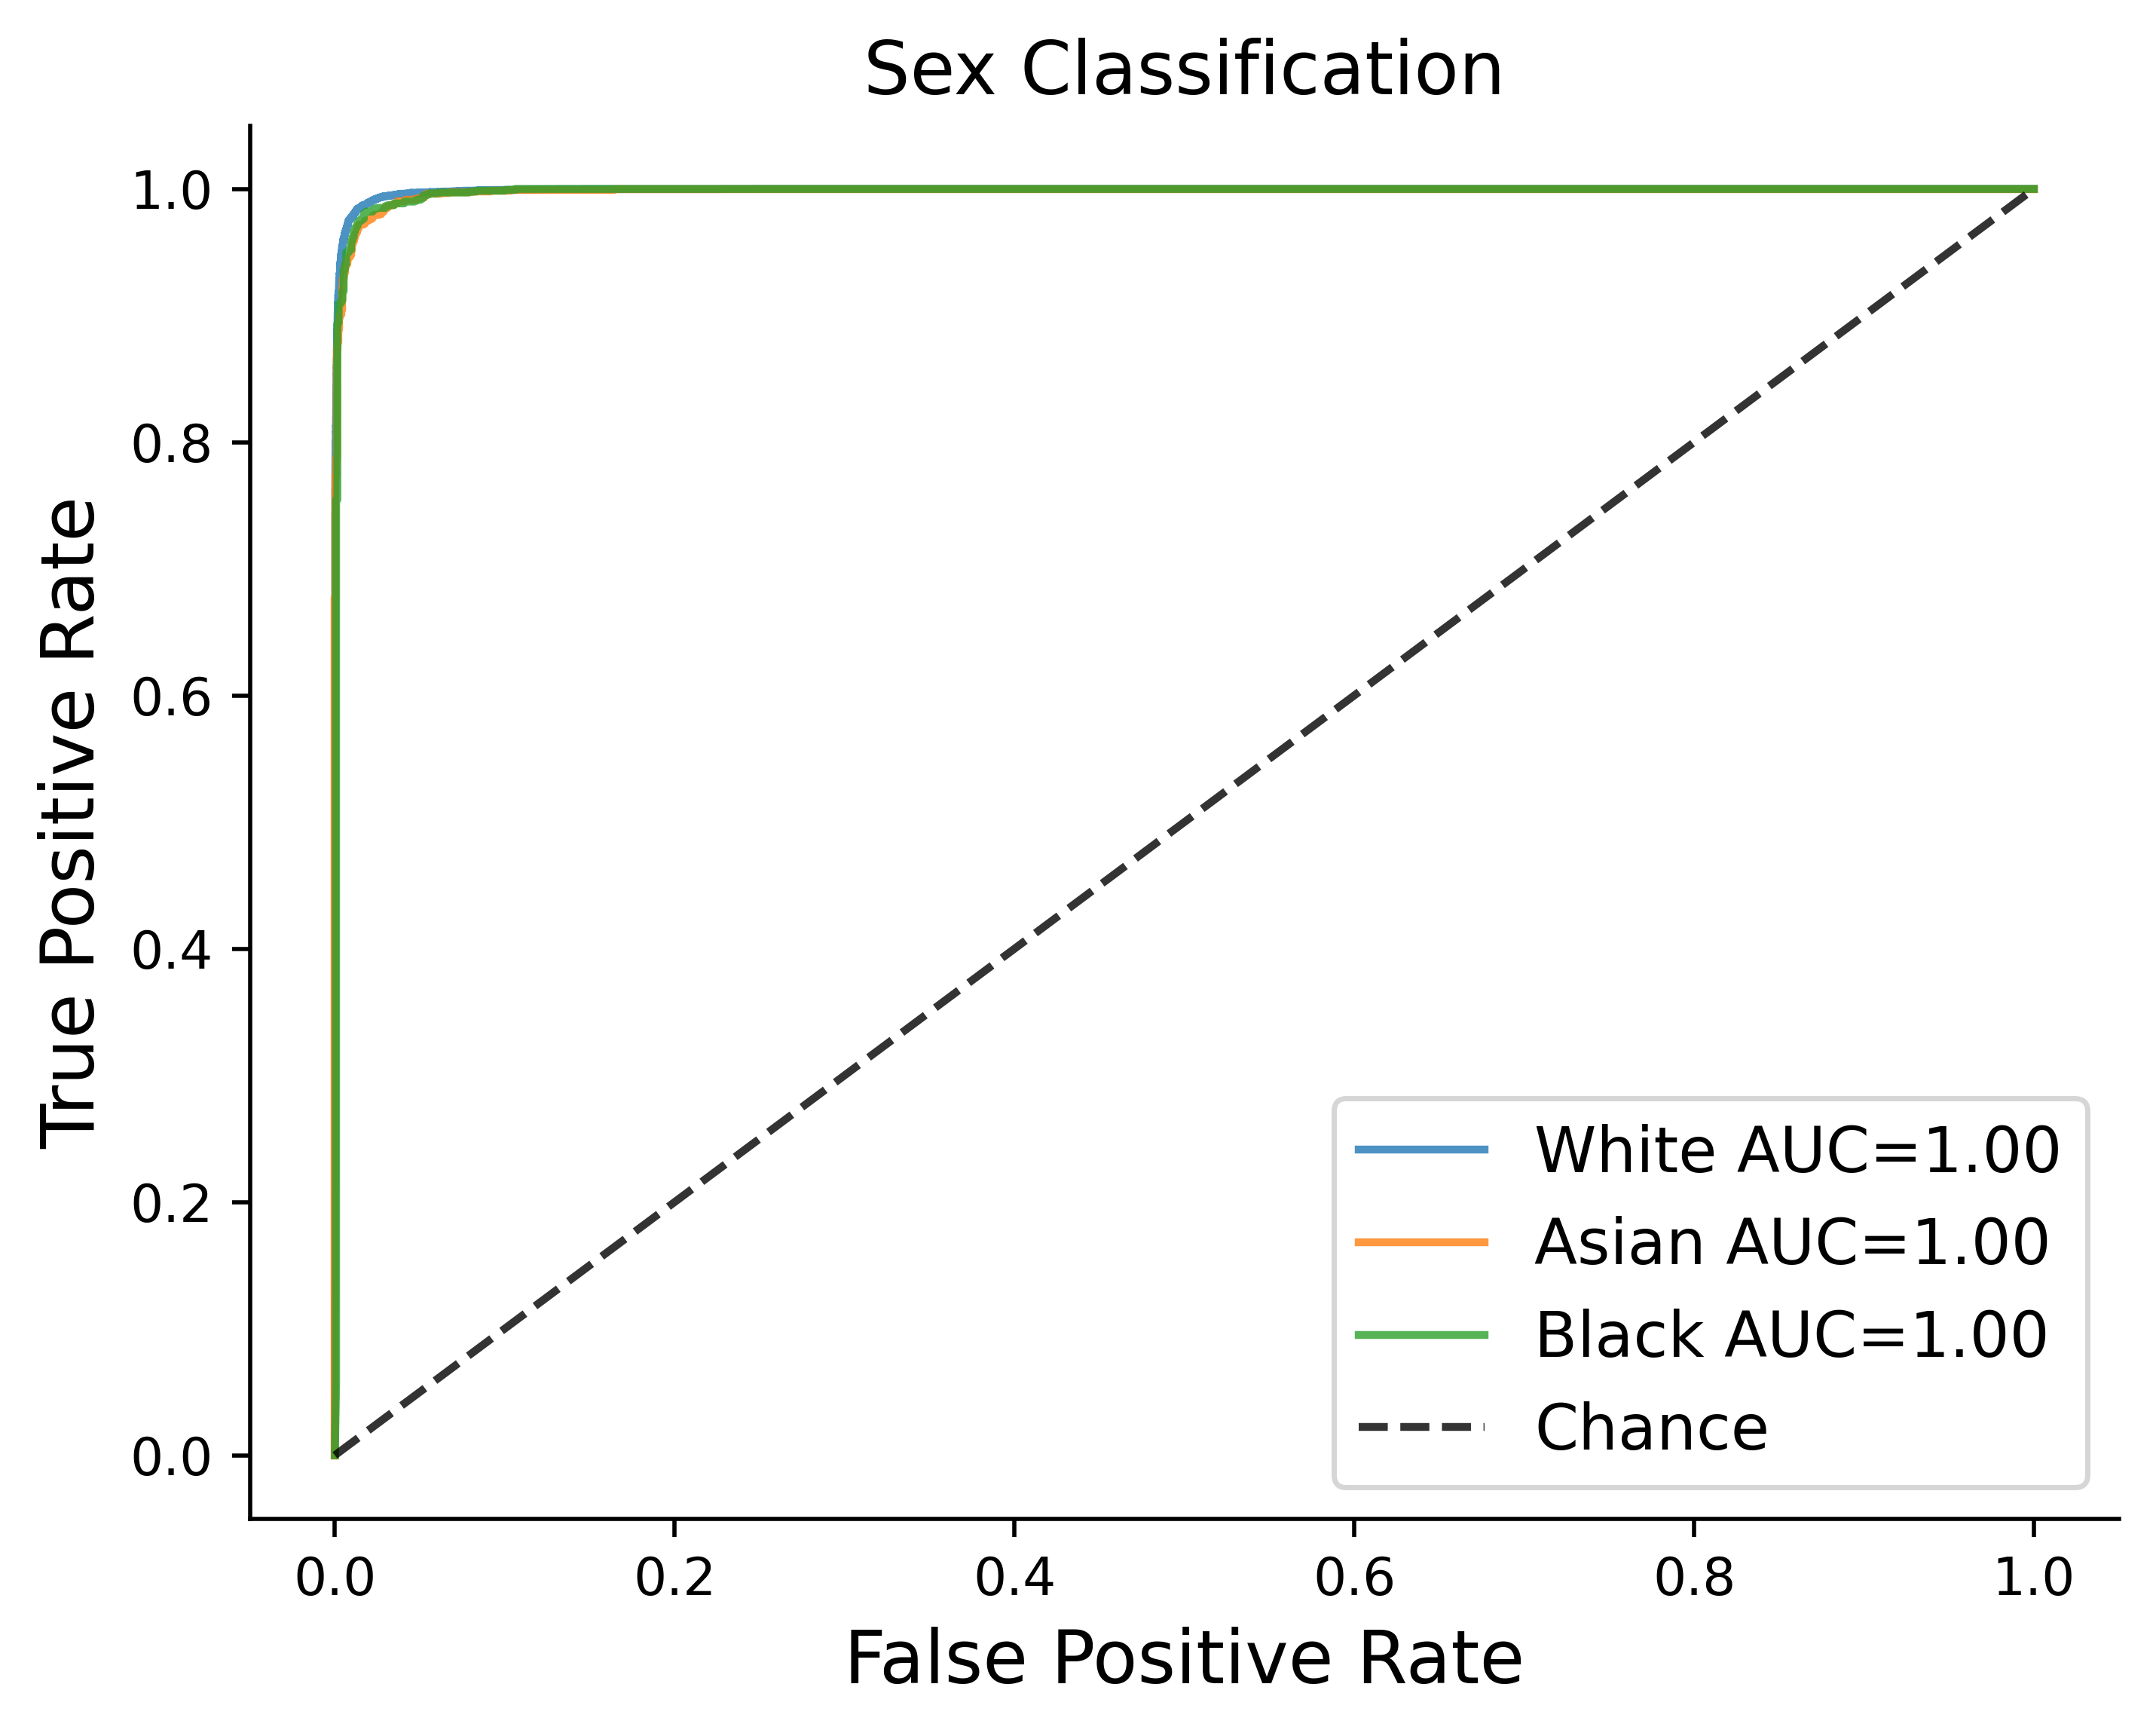

In [184]:
fig, ax = plt.subplots(dpi=500)
plt.plot(fpr_w, tpr_w, lw=1.5, alpha=.8, label='White AUC=%0.2f' % roc_auc_w)
plt.plot(fpr_a, tpr_a, lw=1.5, alpha=.8, label='Asian AUC=%0.2f' % roc_auc_a)
plt.plot(fpr_b, tpr_b, lw=1.5, alpha=.8, label='Black AUC=%0.2f' % roc_auc_b)
ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.title('Sex Classification', fontsize=14)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.spines[['right', 'top']].set_visible(False)
# fig.savefig("CNN-sex.png", bbox_inches='tight', dpi=300)

### Disease Classification 

In [185]:
labels = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices']

In [186]:
import numpy as np
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import recall_score

# Define the permutation test function
def permutation_test(targets, preds, threshold='Global', n_permutations=1000):
    # Calculate the  metrics
    fpr, tpr, thres = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    preds = np.array(preds)

    if threshold == 'Global':
        target_fpr = 0.2
        threshold = thres[np.argmin(np.abs(fpr-target_fpr))]
    else:
        threshold = threshold
        
    tpr_score = recall_score(targets, preds >= threshold, pos_label=1)
    fpr_score = 1 - recall_score(targets, preds >= threshold, pos_label=0)

    # Perform permutation test
    permuted_auc = []
    permuted_tpr = []
    permuted_fpr = []
    for _ in range(n_permutations):
        # Permute the target labels
        keep = np.random.choice(len(targets), size=len(targets))
        permuted_targets = targets[keep]
        permuted_preds = preds[keep]

        # Calculate ROC curve and metrics for permutation
        fpr_permuted, tpr_permuted, _ = roc_curve(permuted_targets, permuted_preds)
        auc_permuted = auc(fpr_permuted, tpr_permuted)
        tpr_permuted_score = recall_score(permuted_targets, permuted_preds >= threshold, pos_label=1)
        fpr_permuted_score = 1 - recall_score(permuted_targets, permuted_preds >= threshold, pos_label=0)
        
        permuted_auc.append(auc_permuted)
        permuted_tpr.append(tpr_permuted_score)
        permuted_fpr.append(fpr_permuted_score)

    # Calculate 95% confidence intervals
    alpha = 0.05
    auc_ci = np.percentile(permuted_auc, [100 * alpha / 2, 100 * (1 - alpha / 2)]).round(5)
    tpr_ci = np.percentile(permuted_tpr, [100 * alpha / 2, 100 * (1 - alpha / 2)]).round(5)
    fpr_ci = np.percentile(permuted_fpr, [100 * alpha / 2, 100 * (1 - alpha / 2)]).round(5)

    return roc_auc, auc_ci, tpr, tpr_score, tpr_ci, fpr, fpr_score, fpr_ci, threshold


In [187]:
df_metrics_multitask = pd.DataFrame(columns=['Model', 'Label', 'Race', 'TPR', 'FPR', 'AUC', 'TPR_CI', 'FPR_CI', 'AUC_CI'])

fig, ax = plt.subplots(7, 2, figsize=(10,20), dpi=300)
ax = ax.ravel()

for label, label_name in enumerate(labels):
    cnn_pred_disease['race'] = df['race']
    cnn_pred_disease['sex'] = df['sex']
    cnn_pred_disease['age'] = df['age']
    cnn_pred_disease[label_name] = df[label_name]
    
    # subgroups
    cnn_pred_m = cnn_pred_disease[cnn_pred_disease['sex'] == 'Male'].copy()
    cnn_pred_f = cnn_pred_disease[cnn_pred_disease['sex'] == 'Female'].copy()
    cnn_pred_w = cnn_pred_disease[cnn_pred_disease['race'] == white].copy()
    cnn_pred_a = cnn_pred_disease[cnn_pred_disease['race'] == asian].copy()
    cnn_pred_b = cnn_pred_disease[cnn_pred_disease['race'] == black].copy()

    preds = cnn_pred_disease['class_' + str(label)]
    targets = np.array(cnn_pred_disease['target_' + str(label)])

    preds_m = cnn_pred_m['class_' + str(label)]
    targets_m = np.array(cnn_pred_m['target_' + str(label)])

    preds_f = cnn_pred_f['class_' + str(label)]
    targets_f = np.array(cnn_pred_f['target_' + str(label)])

    preds_w = cnn_pred_w['class_' + str(label)]
    targets_w = np.array(cnn_pred_w['target_' + str(label)])

    preds_a = cnn_pred_a['class_' + str(label)]
    targets_a = np.array(cnn_pred_a['target_' + str(label)])

    preds_b = cnn_pred_b['class_' + str(label)]
    targets_b = np.array(cnn_pred_b['target_' + str(label)])

    # Calculate confidence intervals using permutation tests
    roc_auc, roc_auc_ci, tpr, tpr_score, tpr_ci, fpr, fpr_score, fpr_ci, op = permutation_test(targets, preds, threshold='Global')
    #print('All \t Threshold %0.4f' % op)

    roc_auc_w, roc_auc_ci_w, tpr_w, tpr_score_w, tpr_ci_w, fpr_w, fpr_score_w, fpr_ci_w, op = permutation_test(targets_w, preds_w, threshold=op)
    roc_auc_a, roc_auc_ci_a, tpr_a, tpr_score_a, tpr_ci_a, fpr_a, fpr_score_a, fpr_ci_a, op = permutation_test(targets_a, preds_a, threshold=op)
    roc_auc_b, roc_auc_ci_b, tpr_b, tpr_score_b, tpr_ci_b, fpr_b, fpr_score_b, fpr_ci_b, op = permutation_test(targets_b, preds_b, threshold=op)  
    roc_auc_m, roc_auc_ci_m, tpr_m, tpr_score_m, tpr_ci_m, fpr_m, fpr_score_m, fpr_ci_m, op = permutation_test(targets_m, preds_m, threshold=op)
    roc_auc_f, roc_auc_ci_f, tpr_f, tpr_score_f, tpr_ci_f, fpr_f, fpr_score_f, fpr_ci_f, op = permutation_test(targets_f, preds_f, threshold=op)

    ax[label].plot(fpr, tpr, lw=1.5, alpha=.8, label='All AUC=%0.2f' % roc_auc)
    ax[label].plot(fpr_w, tpr_w, lw=1.5, alpha=.8, label='White AUC=%0.2f' % roc_auc_w)
    ax[label].plot(fpr_a, tpr_a, lw=1.5, alpha=.8, label='Asian AUC=%0.2f' % roc_auc_a)
    ax[label].plot(fpr_b, tpr_b, lw=1.5, alpha=.8, label='Black AUC=%0.2f' % roc_auc_b)
    ax[label].plot(fpr_f, tpr_f, lw=1.5, alpha=.8, label='Female AUC=%0.2f' % roc_auc_f)
    ax[label].plot(fpr_m, tpr_m, lw=1.5, alpha=.8, label='Male AUC=%0.2f' % roc_auc_m)

    #ax[label].gca().set_prop_cycle(None)
    ax[label].plot(fpr_score, tpr_score, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_score,fpr_score))
    ax[label].plot(fpr_score_w, tpr_score_w, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_score_w,fpr_score_w))
    ax[label].plot(fpr_score_a, tpr_score_a, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_score_a,fpr_score_a))
    ax[label].plot(fpr_score_b, tpr_score_b, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_score_b,fpr_score_b))
    ax[label].plot(fpr_score_f, tpr_score_f, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_score_f,fpr_score_f))
    ax[label].plot(fpr_score_m, tpr_score_m, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_score_m,fpr_score_m))

    ax[label].legend(loc="lower right", fontsize=8, ncol=2)
    title = labels[label] + ' - Original Test-set'
    ax[label].plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', label='Chance', alpha=.8)
    ax[label].set_xlabel('False Positive Rate', fontsize=8)
    ax[label].set_ylabel('True Positive Rate', fontsize=8)
    ax[label].set_title(title, fontsize=8)
    ax[label].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
    ax[label].spines[['right', 'top']].set_visible(False)
    
    # Append metrics and confidence intervals to the DataFrame
    metrics_to_append = [
        {'Model': 'Multi Task', 'Label': labels[label], 'Race': 'All', 'TPR': tpr_score, 'FPR': fpr_score, 'AUC': roc_auc,
         'TPR_CI': tpr_ci, 'FPR_CI': fpr_ci, 'AUC_CI': roc_auc_ci},
        {'Model': 'Multi Task', 'Label': labels[label], 'Race': 'White', 'TPR': tpr_score_w, 'FPR': fpr_score_w, 'AUC': roc_auc_w,
            'TPR_CI': tpr_ci_w, 'FPR_CI': fpr_ci_w, 'AUC_CI': roc_auc_ci_w},
        {'Model': 'Multi Task', 'Label': labels[label], 'Race': 'Asian', 'TPR': tpr_score_a, 'FPR': fpr_score_a, 'AUC': roc_auc_a,
            'TPR_CI': tpr_ci_a, 'FPR_CI': fpr_ci_a, 'AUC_CI': roc_auc_ci_a},
        {'Model': 'Multi Task', 'Label': labels[label], 'Race': 'Black', 'TPR': tpr_score_b, 'FPR': fpr_score_b, 'AUC': roc_auc_b,
            'TPR_CI': tpr_ci_b, 'FPR_CI': fpr_ci_b, 'AUC_CI': roc_auc_ci_b},
        {'Model': 'Multi Task', 'Label': labels[label], 'Race': 'Female', 'TPR': tpr_score_f, 'FPR': fpr_score_f, 'AUC': roc_auc_f,
            'TPR_CI': tpr_ci_f, 'FPR_CI': fpr_ci_f, 'AUC_CI': roc_auc_ci_f},
        {'Model': 'Multi Task', 'Label': labels[label], 'Race': 'Male', 'TPR': tpr_score_m, 'FPR': fpr_score_m, 'AUC': roc_auc_m,
            'TPR_CI': tpr_ci_m, 'FPR_CI': fpr_ci_m, 'AUC_CI': roc_auc_ci_m} ]

    df_metrics_multitask = pd.concat([df_metrics_multitask, pd.DataFrame(metrics_to_append)], ignore_index=True)

plt.tight_layout()
plt.show()

In [ ]:
df_metrics_multitask

,Model,Label,Race,TPR,FPR,AUC,TPR_CI,FPR_CI,AUC_CI
0,Multi Task,No Finding,All,0.800963,0.200142,0.873537,"[0.79208, 0.81416]","[0.19705, 0.2029]","[0.86923, 0.87959]"
1,Multi Task,No Finding,White,0.793441,0.197738,0.870734,"[0.77901, 0.80401]","[0.19173, 0.19982]","[0.86679, 0.87535]"
2,Multi Task,No Finding,Asian,0.811563,0.191588,0.882303,"[0.79051, 0.81963]","[0.18481, 0.20084]","[0.87289, 0.89527]"
3,Multi Task,No Finding,Black,0.843333,0.245298,0.877982,"[0.79678, 0.88212]","[0.23483, 0.25632]","[0.86032, 0.90044]"
4,Multi Task,No Finding,Female,0.770270,0.177776,0.871866,"[0.76755, 0.78321]","[0.17299, 0.18178]","[0.86665, 0.87717]"
...,...,...,...,...,...,...,...,...,...
79,Multi Task,Support Devices,White,0.766867,0.203832,0.853561,"[0.76538, 0.77261]","[0.19894, 0.20765]","[0.85161, 0.85632]"
80,Multi Task,Support Devices,Asian,0.782237,0.203448,0.855639,"[0.77547, 0.79148]","[0.1867, 0.21738]","[0.85055, 0.86398]"
81,Multi Task,Support Devices,Black,0.778019,0.154806,0.889193,"[0.77048, 0.79324]","[0.14094, 0.16658]","[0.88156, 0.90001]"
82,Multi Task,Support Devices,Female,0.770036,0.189718,0.860848,"[0.76306, 0.77192]","[0.1799, 0.20431]","[0.85195, 0.86532]"


### Did multitask prediction improve prediction accuracy? 
- Multitask prediction can improve prediction accuracy when the tasks are related
- However, if tasks are too dissimilar the model can be overwhelmed by the complexity of trying to learn multiple tasks, thus not improving prediction accuracy 

In [ ]:
# Read in single task predictions
data_dir = '../chexpert-disease/predictions/'
cnn_single_pred_disease = pd.read_csv(data_dir + 'predictions.test.csv')

In [ ]:
# Create an empty DataFrame to store the results
df_metrics_singletask = pd.DataFrame(columns=['Model', 'Label', 'Race', 'TPR', 'FPR', 'AUC', 'TPR_CI', 'FPR_CI', 'AUC_CI'])

for label, label_name in enumerate(labels):
    cnn_single_pred_disease['race'] = df['race']
    cnn_single_pred_disease['sex'] = df['sex']
    cnn_single_pred_disease['age'] = df['age']
    cnn_single_pred_disease[label_name] = df[label_name]
    
    # subgroups
    cnn_pred_m = cnn_single_pred_disease[cnn_pred_disease['sex'] == 'Male'].copy()
    cnn_pred_f = cnn_single_pred_disease[cnn_pred_disease['sex'] == 'Female'].copy()
    cnn_pred_w = cnn_single_pred_disease[cnn_pred_disease['race'] == white].copy()
    cnn_pred_a = cnn_single_pred_disease[cnn_pred_disease['race'] == asian].copy()
    cnn_pred_b = cnn_single_pred_disease[cnn_pred_disease['race'] == black].copy()

    preds = cnn_single_pred_disease['class_' + str(label)]
    targets = np.array(cnn_single_pred_disease['target_' + str(label)])

    preds_m = cnn_pred_m['class_' + str(label)]
    targets_m = np.array(cnn_pred_m['target_' + str(label)])

    preds_f = cnn_pred_f['class_' + str(label)]
    targets_f = np.array(cnn_pred_f['target_' + str(label)])

    preds_w = cnn_pred_w['class_' + str(label)]
    targets_w = np.array(cnn_pred_w['target_' + str(label)])

    preds_a = cnn_pred_a['class_' + str(label)]
    targets_a = np.array(cnn_pred_a['target_' + str(label)])

    preds_b = cnn_pred_b['class_' + str(label)]
    targets_b = np.array(cnn_pred_b['target_' + str(label)])

    # Calculate confidence intervals using permutation tests
    roc_auc, roc_auc_ci, tpr, tpr_score, tpr_ci, fpr, fpr_score, fpr_ci, op = permutation_test(targets, preds, threshold='Global')
    #print('All \t Threshold %0.4f' % op)

    roc_auc_w, roc_auc_ci_w, tpr_w, tpr_score_w, tpr_ci_w, fpr_w, fpr_score_w, fpr_ci_w, op = permutation_test(targets_w, preds_w, threshold=op)
    roc_auc_a, roc_auc_ci_a, tpr_a, tpr_score_a, tpr_ci_a, fpr_a, fpr_score_a, fpr_ci_a, op = permutation_test(targets_a, preds_a, threshold=op)
    roc_auc_b, roc_auc_ci_b, tpr_b, tpr_score_b, tpr_ci_b, fpr_b, fpr_score_b, fpr_ci_b, op = permutation_test(targets_b, preds_b, threshold=op)  
    roc_auc_m, roc_auc_ci_m, tpr_m, tpr_score_m, tpr_ci_m, fpr_m, fpr_score_m, fpr_ci_m, op = permutation_test(targets_m, preds_m, threshold=op)
    roc_auc_f, roc_auc_ci_f, tpr_f, tpr_score_f, tpr_ci_f, fpr_f, fpr_score_f, fpr_ci_f, op = permutation_test(targets_f, preds_f, threshold=op)

    # Append metrics and confidence intervals to the DataFrame
    metrics_to_append = [
        {'Model': 'Single Task', 'Label': labels[label], 'Race': 'All', 'TPR': tpr_score, 'FPR': fpr_score, 'AUC': roc_auc,
         'TPR_CI': tpr_ci, 'FPR_CI': fpr_ci, 'AUC_CI': roc_auc_ci},
        {'Model': 'Single Task', 'Label': labels[label], 'Race': 'White', 'TPR': tpr_score_w, 'FPR': fpr_score_w, 'AUC': roc_auc_w,
            'TPR_CI': tpr_ci_w, 'FPR_CI': fpr_ci_w, 'AUC_CI': roc_auc_ci_w},
        {'Model': 'Single Task', 'Label': labels[label], 'Race': 'Asian', 'TPR': tpr_score_a, 'FPR': fpr_score_a, 'AUC': roc_auc_a,
            'TPR_CI': tpr_ci_a, 'FPR_CI': fpr_ci_a, 'AUC_CI': roc_auc_ci_a},
        {'Model': 'Single Task', 'Label': labels[label], 'Race': 'Black', 'TPR': tpr_score_b, 'FPR': fpr_score_b, 'AUC': roc_auc_b,
            'TPR_CI': tpr_ci_b, 'FPR_CI': fpr_ci_b, 'AUC_CI': roc_auc_ci_b},
        {'Model': 'Single Task', 'Label': labels[label], 'Race': 'Female', 'TPR': tpr_score_f, 'FPR': fpr_score_f, 'AUC': roc_auc_f,
            'TPR_CI': tpr_ci_f, 'FPR_CI': fpr_ci_f, 'AUC_CI': roc_auc_ci_f},
        {'Model': 'Single Task', 'Label': labels[label], 'Race': 'Male', 'TPR': tpr_score_m, 'FPR': fpr_score_m, 'AUC': roc_auc_m,
            'TPR_CI': tpr_ci_m, 'FPR_CI': fpr_ci_m, 'AUC_CI': roc_auc_ci_m} ]

    df_metrics_singletask = pd.concat([df_metrics_singletask, pd.DataFrame(metrics_to_append)], ignore_index=True)


KeyError: 'race'

In [ ]:
df_metrics = pd.concat([df_metrics_singletask, df_metrics_multitask], ignore_index=True)
df_metrics.to_csv('predictions/df_metrics.csv', index=False)

,Model,Label,Race,TPR,FPR,AUC,TPR_CI,FPR_CI,AUC_CI
0,Single Task,No Finding,All,0.806100,0.199829,0.875890,"[0.79687, 0.82404]","[0.19645, 0.20149]","[0.8696, 0.88339]"
1,Single Task,No Finding,White,0.800681,0.194465,0.872907,"[0.78879, 0.80574]","[0.18979, 0.19562]","[0.86879, 0.87738]"
2,Single Task,No Finding,Asian,0.813704,0.203936,0.881088,"[0.78888, 0.8193]","[0.19814, 0.21347]","[0.86888, 0.88253]"
3,Single Task,No Finding,Black,0.836667,0.251431,0.886740,"[0.80508, 0.84905]","[0.24111, 0.26163]","[0.87515, 0.90012]"
4,Single Task,No Finding,Female,0.797297,0.204617,0.872036,"[0.76873, 0.80645]","[0.20347, 0.21145]","[0.86164, 0.87856]"
...,...,...,...,...,...,...,...,...,...
163,Multi Task,Support Devices,White,0.766867,0.203832,0.853561,"[0.76538, 0.77261]","[0.19894, 0.20765]","[0.85161, 0.85632]"
164,Multi Task,Support Devices,Asian,0.782237,0.203448,0.855639,"[0.77547, 0.79148]","[0.1867, 0.21738]","[0.85055, 0.86398]"
165,Multi Task,Support Devices,Black,0.778019,0.154806,0.889193,"[0.77048, 0.79324]","[0.14094, 0.16658]","[0.88156, 0.90001]"
166,Multi Task,Support Devices,Female,0.770036,0.189718,0.860848,"[0.76306, 0.77192]","[0.1799, 0.20431]","[0.85195, 0.86532]"


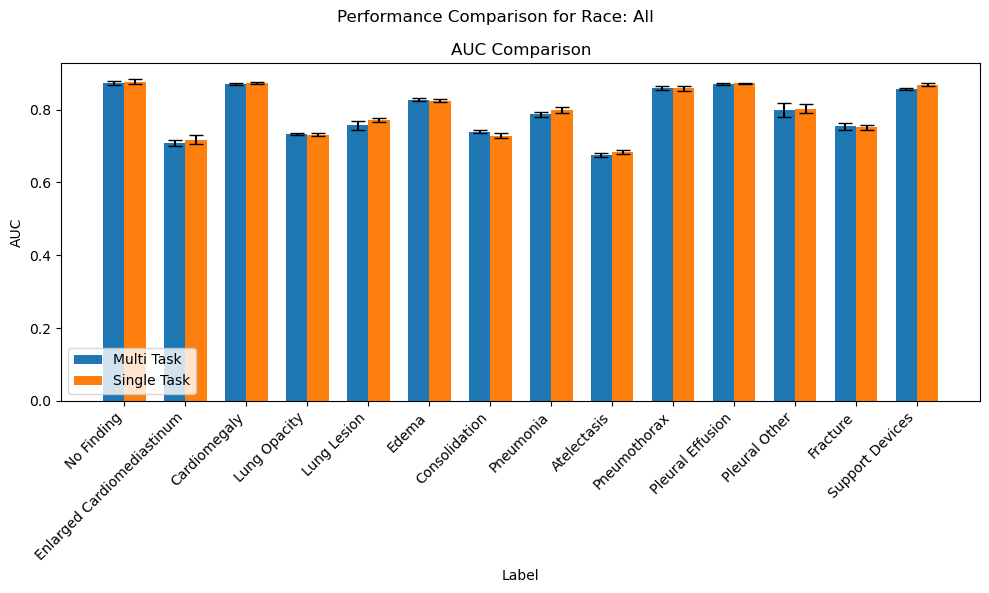

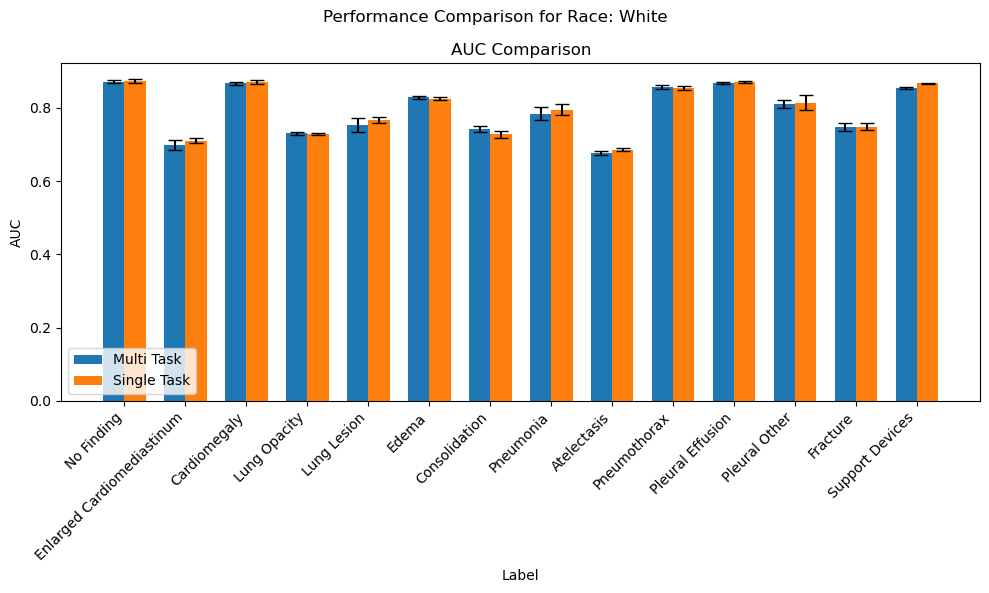

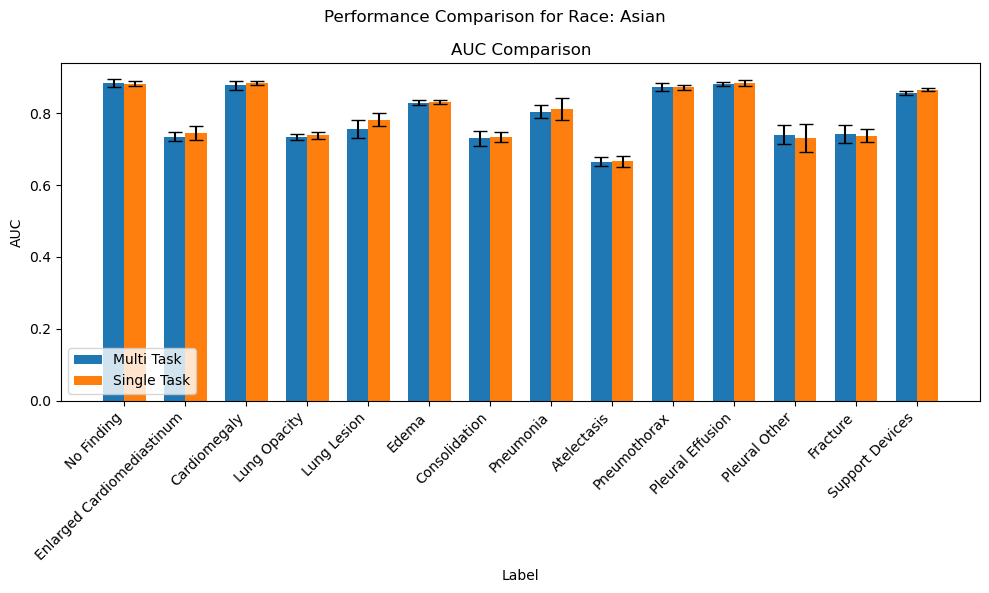

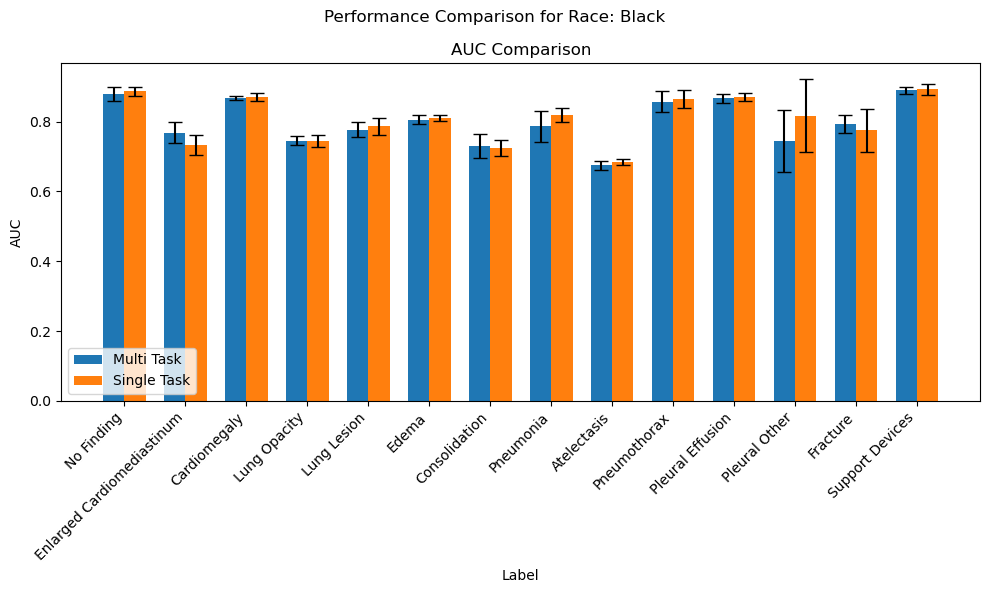

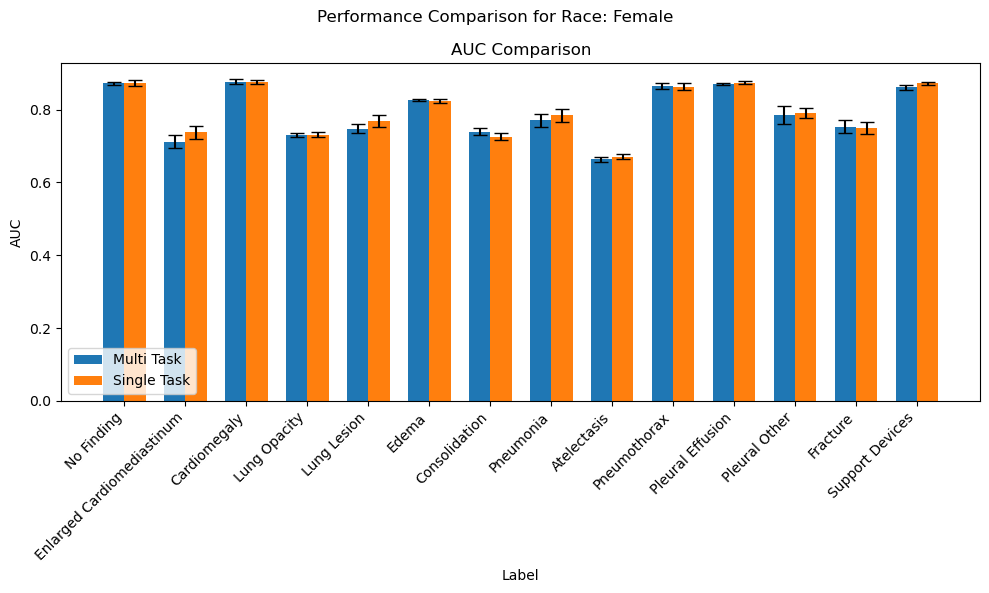

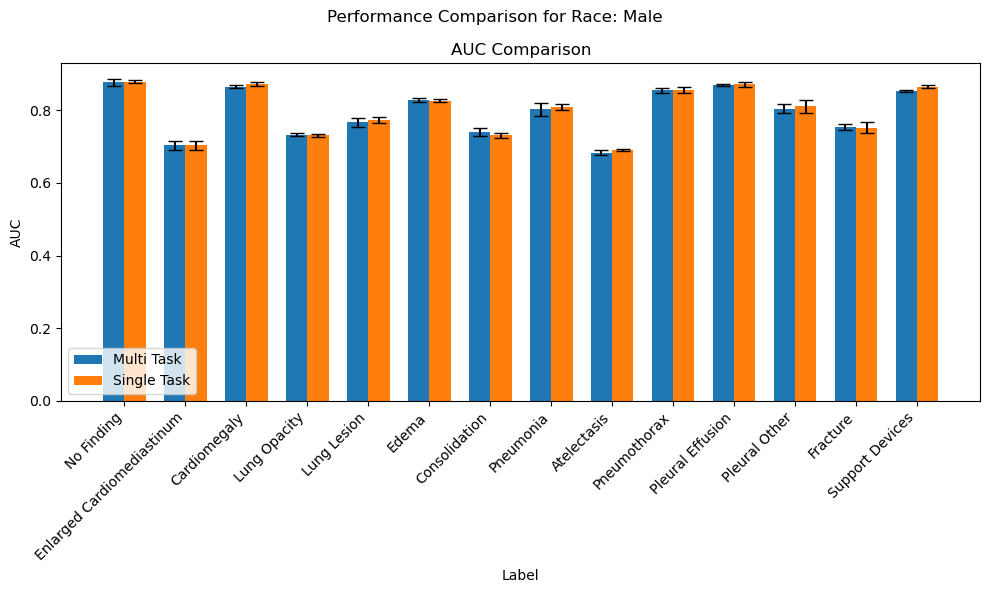

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame named df_metrics with the data

# List of unique labels
labels = df_metrics['Label'].unique()

# List of unique races
races = df_metrics['Race'].unique()

# Set the width of each bar
bar_width = 0.35

# Iterate over each race
for race in races:
    fig, axes = plt.subplots(1, 1, figsize=(10, 6))
    fig.suptitle(f"Performance Comparison for Race: {race}")
    
    # Filter data for the current race
    race_data = df_metrics[df_metrics['Race'] == race]
    
    # Lists to store AUC values for multitask and single task models
    auc_multitask = []
    auc_singletask = []
    
    # Lists to store the lower and upper bounds of AUC confidence intervals
    auc_multi_ci_lower = []
    auc_multi_ci_upper = []
    auc_single_ci_lower = []
    auc_single_ci_upper = []

    # Create an array of x positions for the data points
    x = np.arange(len(labels))
    
    for label in labels:
        # Filter data for the current label
        label_data = race_data[race_data['Label'] == label]
        
        # Get the AUC values and confidence intervals for multitask and single task models
        auc_multitask_value = label_data[label_data['Model'] == 'Multi Task']['AUC'].values[0]
        auc_singletask_value = label_data[label_data['Model'] == 'Single Task']['AUC'].values[0]
        
        auc_multitask.append(auc_multitask_value)
        auc_singletask.append(auc_singletask_value)
        
        # Extract confidence intervals
        auc_multi_ci = label_data[label_data['Model'] == 'Multi Task']['AUC_CI'].values[0]
        auc_multi_ci_lower.append(auc_multi_ci[0])
        auc_multi_ci_upper.append(auc_multi_ci[1])

        # Extract confidence intervals
        auc_single_ci = label_data[label_data['Model'] == 'Single Task']['AUC_CI'].values[0]
        auc_single_ci_lower.append(auc_single_ci[0])
        auc_single_ci_upper.append(auc_single_ci[1])
    
    # Create the bar plot for AUC comparison
    axes.bar(x - bar_width/2, auc_multitask, width=bar_width, label="Multi Task")
    axes.bar(x + bar_width/2, auc_singletask, width=bar_width, label="Single Task")
    
    # Add error bars for AUC confidence intervals
    axes.errorbar(x - bar_width/2, auc_multitask, yerr=[(a - b) / 2 for a, b in zip(auc_multi_ci_upper, auc_multi_ci_lower)], 
                  fmt='none', ecolor='black', capsize=5)
    axes.errorbar(x + bar_width/2, auc_singletask, yerr=[(a - b) / 2 for a, b in zip(auc_single_ci_upper, auc_single_ci_lower)], 
                  fmt='none', ecolor='black', capsize=5)
    
    axes.set_title("AUC Comparison")
    axes.set_xticks(x)
    axes.set_xticklabels(labels, rotation=45, ha='right')
    axes.set_xlabel("Label")
    axes.set_ylabel("AUC")
    axes.legend(loc='best')
    
    # Adjust layout to prevent subplots from overlapping
    plt.tight_layout()
    
    # Save or display the plot
    plt.savefig(f"performance_comparison_{race}.png")
    plt.show()
